In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl
Training results should now be reproducible.


# Train model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.0055905797197103695,
    "weight_decay": 9.123321505007701e-06,
    "momentum": 0.791610254744395,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "augmentation": {
    "enabled": false,
    "transform": "Compose(\n    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)\n    RandomHorizontalFlip(p=0.5)\n    ToTensor()\n    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n)",
    "dropout_rate": 0.3
  },
  "validation_freq": 1,
  "mft": {
    "enabled": false,
    "k": 0
  },
  "fixmatch": false,
  "unsup_weight": 0.5,
  "contrastive_temp": 0.1,
  "num_classes": 37,
  "use_scheduler": false
}
Training result:
{
  "training_losses": [2.7244906463930683, 0.9616074523618144, 0.41874201563737723, 0.24784056802270232, 0.17255057638851545, 0.1201875717729650

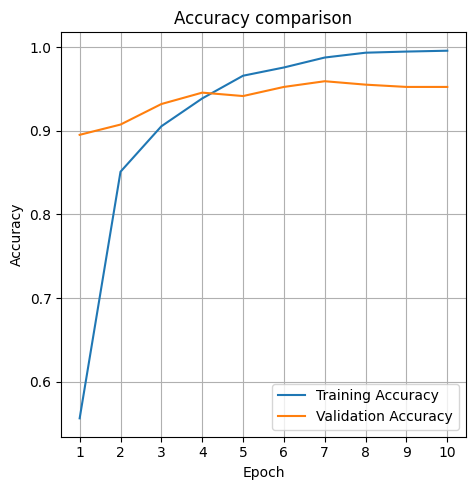

In [2]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_with_train_val_plot, run_with_different_seeds
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    #class_fractions=(0.2,)*37,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.0055905797197103695,
        weight_decay=9.123321505007701e-06,
        momentum=0.791610254744395,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    augmentation=AugmentationParams(
        enabled=False,
        transform=augmentation.to_transform(architecture, ["resize", "flip"])
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7245, Train Acc: 55.63%, Val Acc: 89.51%
Epoch [2/10], Loss: 0.9616, Train Acc: 85.10%, Val Acc: 90.74%
Epoch [3/10], Loss: 0.4187, Train Acc: 90.53%, Val Acc: 93.19%
Epoch [4/10], Loss: 0.2478, Train Acc: 93.86%, Val Acc: 94.55%
Epoch [5/10], Loss: 0.1726, Train Acc: 96.57%, Val Acc: 94.14%
Epoch [6/10], Loss: 0.1202, Train Acc: 97.56%, Val Acc: 95.23%
Epoch [7/10], Loss: 0.0947, Train Acc: 98.74%, Val Acc: 95.91%
Epoch [8/10], Loss: 0.0637, Train Acc: 99.32%, Val Acc: 95.50%
Epoch [9/10], Loss: 0.0475, Train Acc: 99.46%, Val Acc: 95.23%
Epoch [10/10], Loss: 0.0680, Train Acc: 99.56%, Val Acc: 95.23%
Total elapsed: 134.08s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/1be2a40321d6d9e76a729e167ce8afc3.pth


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7356, Train Acc: 53.77%, Val Acc: 89.78%
Epoch [2/10], Loss: 0.9832, Train Acc: 84.18%, Val Acc: 91.28%
Epoch [3/10], Loss: 0.4186, Train Acc: 90.60%, Val Acc: 93.46%
Epoch [4/10], Loss: 0.2671, Train Acc: 93.69%, Val Acc: 94.82%
Epoch [5/10], Loss: 0.1719, Train Acc: 96.57%, Val Acc: 93.73%
Epoch [6/10], Loss: 0.1221, Train Acc: 97.66%, Val Acc: 94.28%
Epoch [7/10], Loss: 0.1000, Train Acc: 98.64%, Val Acc: 95.78%
Epoch [8/10], Loss: 0.0610, Train Acc: 99.32%, Val Acc: 95.10%
Epoch [9/10], Loss: 0.0577, Train Acc: 99.05%, Val Acc: 94.69%
Epoch [10/10], Loss: 0.0652, Train Acc: 99.52%, Val Acc: 94.82%
Total elapsed: 129.30s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/09d8b7707a5010776be4f7db749c6084.pth


Update step:   0%|          | 0/930 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.7257, Train Acc: 56.52%, Val Acc: 88.96%
Epoch [2/10], Loss: 0.9612, Train Acc: 84.79%, Val Acc: 91.14%
Epoch [3/10], Loss: 0.4199, Train Acc: 90.70%, Val Acc: 93.05%
Epoch [4/10], Loss: 0.2597, Train Acc: 94.26%, Val Acc: 93.73%
Epoch [5/10], Loss: 0.1656, Train Acc: 96.16%, Val Acc: 94.01%
Epoch [6/10], Loss: 0.1229, Train Acc: 97.66%, Val Acc: 94.28%
Epoch [7/10], Loss: 0.0941, Train Acc: 98.30%, Val Acc: 95.50%
Epoch [8/10], Loss: 0.0675, Train Acc: 99.02%, Val Acc: 94.82%
Epoch [9/10], Loss: 0.0537, Train Acc: 99.39%, Val Acc: 94.69%
Epoch [10/10], Loss: 0.0698, Train Acc: 99.32%, Val Acc: 95.10%
Total elapsed: 132.71s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/51002b4efe579394d602b1d21ed055a0.pth


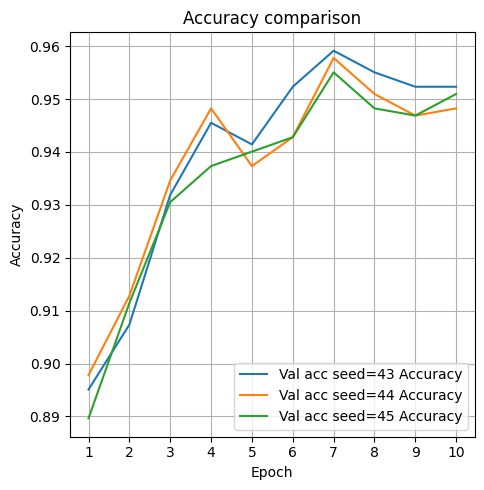

In [3]:
# Second plot: Rerun training multiple times with different seed
run_with_different_seeds(dataset_params, baseline_params, trials=3)

Running trial 1/2 for augmentation.enabled=False
Running trial 2/2 for augmentation.enabled=False
Running trial 1/2 for augmentation.enabled=True,augmentation.transform=Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
),n_epochs=10
Running trial 2/2 for augmentation.enabled=True,augmentation.transform=Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
),n_epochs=10
Running trial 1/2 for augmentation.enabled=True,augmentation.transform=Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False

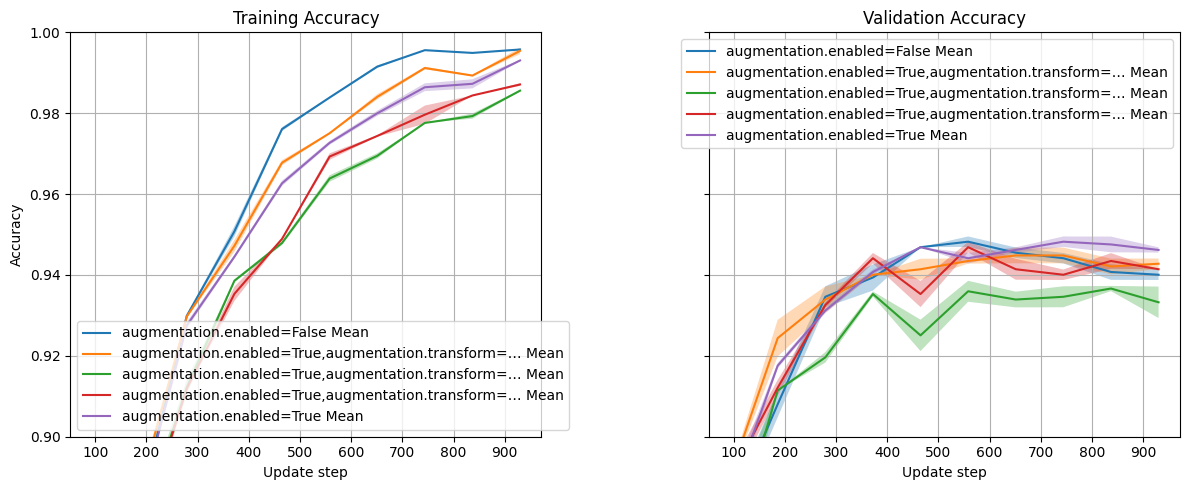

In [89]:
from evaluation import override_param_sets, evaluate_runs_ci, evaluate_runs_print
from run import run_multiple

overrides = [
    dict(augmentation=dict(enabled=False)),
    dict(augmentation=dict(enabled=True, transform=augmentation.to_transform(architecture, ["resize"])), n_epochs=10),
    dict(augmentation=dict(enabled=True,
                           transform=augmentation.to_transform(architecture, ["resize", "flip", "rotate"])),
         n_epochs=10),
    dict(augmentation=dict(enabled=True,
                           transform=augmentation.to_transform(architecture, ["resize", "flip", "colorjitter"])),
         n_epochs=10),

    dict(augmentation=dict(enabled=True)),
    #dict(augmentation=dict(enabled=True, transform=augmentation.auto_transform(baseline_params.architecture)), n_epochs=20),

    #dict(augmentation=dict(enabled=True), optimizer=dict(learning_rate=0.0055905797197103695, momentum=0.791610254744395)),
    #dict(augmentation=dict(enabled=True), optimizer=dict(momentum=0.9)),
    #dict(augmentation=dict(enabled=True), optimizer=dict(learning_rate=0.005)),
]
param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, param_sets, determinism, invalidate=False, trials=2)
evaluate_runs_print(results)
evaluate_runs_ci(results)


# Test model

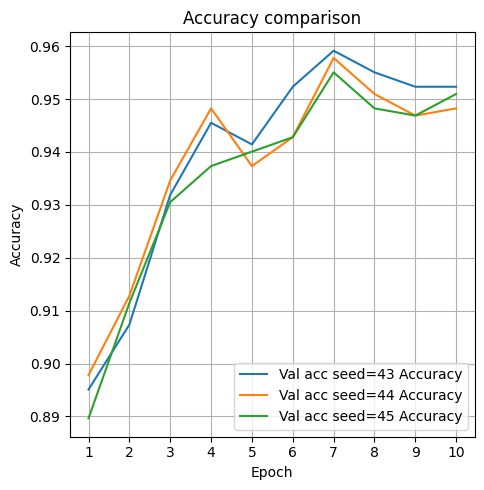

Test size: 3669
Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/fdb012534425c2d2f7babe88be90c6ab.pth (epoch 10)


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 92.45 %
Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/1be2a40321d6d9e76a729e167ce8afc3.pth (epoch 10)


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 92.45 %
Trying to load trainer from disk...


In [ ]:
from evaluation import evaluate_final_test_accuracy

trials = 3
run_with_different_seeds(dataset_params, baseline_params, trials)
evaluate_final_test_accuracy(
    dataset_params,
    baseline_params,
    determinism,
    trials,
    display_misclassified=True,
)